## import, setup

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

In [2]:
# pretty print a row
def pp_row(df):
    cols = df.columns
    out = df.take(1)
    for i, x in enumerate(out[0]):
        print(cols[i], x)

Need to re-compute coverage summary, so run in cluster mode

In [3]:
APP_NAME = "KF-ShopGrid-Jupyter"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.master","yarn"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 5),
        ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3242'

## args

In [4]:
# # define dates
# max_days_til_dept = 120 # args.days_til_dept
# max_stay_duration = 30 #args.length_of_stay

# missing_search_days_str = [] #args.missing_dates or []
# num_missing_days = len(missing_search_days_str)

# # filter on LOS, to restrict our analysis
# los_start, los_end = 1, 7

# load & prep data

TODO: combine data from different "versions" of shop_vol data

In [ ]:
# coverage input data
input_dir = "/user/kendra.frederick/shop_vol/v5/decoded/with_pcc/"
cov_df = spark.read.option("mergeSchema", True).parquet(input_dir)

In [ ]:
# # NEW: derive shopping dates from data, instead of them being supplied as arguments
# search_start_str = cov_df.select(F.min("searchDt").alias("x")).collect()[0]["x"]
# search_end_str = cov_df.select(F.max("searchDt").alias("x")).collect()[0]["x"]

# search_start = datetime.datetime.strptime(str(search_start_str), "%Y%m%d").date()
# search_end = datetime.datetime.strptime(str(search_end_str), "%Y%m%d").date()

# num_search_days = (search_end - search_start).days + 1
# num_search_days_adj = num_search_days - num_missing_days

# # # OUTBOUND DEPARTURE DATES
# # min_dept_dt = search_start # this includes same-day searches
# # max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
# # max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

# # min_dept_dt, max_dept_dt, max_return_dt
# search_start, search_end, num_search_days

In [8]:
# cov_df.show(5)

+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
| market|outDeptDt|inDeptDt|round_trip|shop_counts|min_fare|pos|currency| pcc|origin|destination|searchDt|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
|SJC-JFK| 20220901|       0|         0|         20|   358.6| US|     USD| OMW|   SJC|        JFK|20220825|
|KBV-BKK| 20220914|       0|         0|         21|  1089.0| TW|     TWD| 4D6|   KBV|        BKK|20220825|
|PUS-BKK| 20221001|20221005|         1|          5|594000.0| KR|     KRW|64T3|   PUS|        BKK|20220825|
|HKG-SFO| 20221029|       0|         0|         48|  769.57| US|     USD| J86|   HKG|        SFO|20220825|
|LHR-BKK| 20221002|20221025|         1|          5|  868.76| GB|     GBP| V8T|   LHR|        BKK|20220825|
+-------+---------+--------+----------+-----------+--------+---+--------+----+------+-----------+--------+
only showing top 5 rows



## look at counts by POS

In [ ]:
pos_cnts = cov_df.groupby('pos').agg(F.sum("shop_counts").alias("shop_counts"))
country_df = spark.read.csv("/data/reference/COUNTRY.CSV", header=True)
pos_cnts = (pos_cnts.join(country_df.select("2_char_code", "name"),
                        on=pos_cnts["pos"] == country_df['2_char_code']
                       )
           .withColumnRenamed("name", "country_name")
           .drop("2_char_code")
          )

pos_cnts = pos_cnts.withColumn("avg_shop_counts", F.col("shop_counts") / num_search_days)

w = Window.partitionBy()
pos_cnts = pos_cnts.withColumn("pct_total_counts", F.col("shop_counts") / F.sum("shop_counts").over(w))

In [31]:
pos_cnts.select("pos", "country_name", "avg_shop_counts", "pct_total_counts").orderBy(F.desc("shop_counts")).show(20)

+---+--------------------+---------------+--------------------+
|pos|        country_name|avg_shop_counts|    pct_total_counts|
+---+--------------------+---------------+--------------------+
| US|       United States|   3.45047425E7|  0.2401325179223534|
| GB|      United Kingdom|   2.00955682E7|  0.1398532213635959|
| HK|           Hong Kong|   1.83262417E7| 0.12753975959897776|
| RU|  Russian Federation|   1.16748298E7| 0.08124988256872011|
| CA|              Canada|      8409945.4|0.058528225924059964|
| IN|               India|      7560299.1| 0.05261519221971016|
| TW|              Taiwan|      6505944.2| 0.04527750822103168|
| DE|             Germany|      6436586.7| 0.04479482120744798|
| AU|           Australia|      4720580.6| 0.03285243776369042|
| TH|            Thailand|      4303281.6| 0.02994828452746557|
| JP|               Japan|      3446556.1|   0.023985983794942|
| KR|  Korea, Republic Of|      2978354.0|0.020727575210396455|
| PH|         Philippines|      1958517.

In [8]:
pos_cnts.count()

129

In [9]:
pos_cnts_pdf = pos_cnts.toPandas()

In [14]:
pos_cnts_pdf.sort_values(by="shop_counts", inplace=True, ascending=False)

In [15]:
pos_cnts_pdf["avg_shop_counts"] = pos_cnts_pdf['shop_counts'] / num_search_days

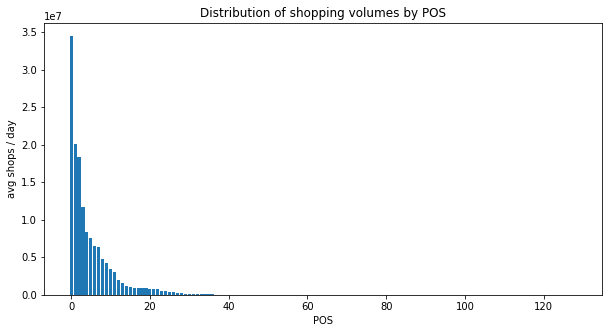

In [17]:
xs = range(len(pos_cnts_pdf))
plt.figure(figsize=(10,5))
plt.bar(xs, pos_cnts_pdf['avg_shop_counts']);
plt.ylabel("avg shops / day")
plt.xlabel("POS")
plt.title("Distribution of shopping volumes by POS");
# plt.xticks[xs[::2]]

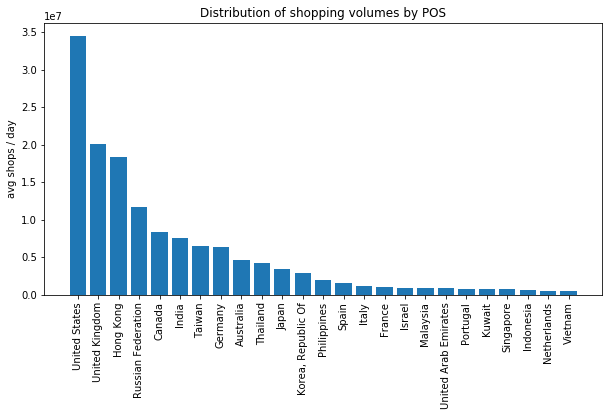

In [19]:
top_n = 25
xs = range(top_n)
plt.figure(figsize=(10,5))
plt.bar(xs, pos_cnts_pdf['avg_shop_counts'][:top_n]);
plt.xticks(xs, pos_cnts_pdf['country_name'], rotation=90)
plt.ylabel("avg shops / day")
# plt.xlabel("POS")
plt.title("Distribution of shopping volumes by POS");

In [21]:
# list(pos_cnts_pdf['pos'][:top_n])

['US',
 'GB',
 'HK',
 'RU',
 'CA',
 'IN',
 'TW',
 'DE',
 'AU',
 'TH',
 'JP',
 'KR',
 'PH',
 'ES',
 'IT',
 'FR',
 'IL',
 'MY',
 'AE',
 'PT',
 'KW',
 'SG',
 'ID',
 'NL',
 'VN']

In [ ]:
pos_to_study = 
['US',
 'GB',
 'HK',
 'CA',
 'IN',
 'TW',
 'DE',
 'AU',
 'TH',
 'JP',
 'KR',
 'PH',
 'ES',
 'IT',
 'FR',
 ]